In [29]:
import PIL
import subprocess
import re
import os
import time
import io
import cv2
import requests
import bs4
import jieba
import jieba.analyse
from IPython.display import display, HTML
import json
from functools import *

import pandas as pd
import sqlite3

In [2]:
%run key.py

In [3]:
from aip import AipOcr

client = AipOcr(AIP_APP_ID, AIP_API_KEY, AIP_SECRET_KEY)

In [39]:
def capture_img():
    subprocess.call('.\\adb\\adb shell /system/bin/screencap -p /sdcard/screenshot.png')
    time.sleep(0.1)
    subprocess.call('.\\adb\\adb pull /sdcard/screenshot.png %s' % './tmp/screenshot.png')
    time.sleep(0.1)
    
    return cv2.imread('./tmp/screenshot.png')


def get_text_in_region(aip_rst, region):
    s = ''
    if 'words_result' in aip_rst:
        words = []
        for p in aip_rst['words_result']:
            loc = p['location']
            if loc['top'] > region[0] and loc['top'] + loc['height'] < region[1] \
                and loc['left'] > region[2] and loc['left'] + loc['width'] < region[3]:
                if loc['left'] < 1080 / 2: # only get words that starts from left
                    words.append(p['words'])
        s = ''.join(words)
        
    if s != '':
        # remove heading, like 1. A. B.
        if re.match(r"^A|B|C|\d+\.|,|。|，", s) != None: 
            ss = re.split(r"\.|,|。|，",s)
            if len(ss) > 1:
                s = ''.join(ss[1:])
            
    return s

def ocr(im, regions):
    _, byte_arr = cv2.imencode('.jpg', im, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
    aip_rst = client.general(byte_arr.tobytes())
    return [get_text_in_region(aip_rst, region) for region in regions]


def go_search(s, engine='google'):
    if engine == 'google':
        os.system('start www.google.com/search?q=%s' % s)
    elif engine == 'baidu':
        os.system('start www.baidu.com/s?wd=%s' % s)

def search(question):
    rst = requests.get('http://www.baidu.com/s?wd=%s&rn=50' % question)
    rst.encoding = 'utf-8'
    search_rst = rst.text
    
    soup = bs4.BeautifulSoup(search_rst, 'html.parser')
    rst = soup.select('div#content_left')[0]
    return rst.text

def search_advanced(question, optional_words, return_string=True, engine='baidu'):
    '''
    Advanced search
    question_words: list of words of the question
    opt_words: list of list of words of the options
    '''
        
    if len(question) > 38:
        question_words = jieba.analyse.extract_tags(question)
    else:
        question_words = [question]
    all_opt_words = list(set(optional_words))
    
    if engine == 'baidu':
        url = 'http://www.baidu.com/s?q1=%s&q2=&q3=%s&q4=&rn=50' % (
            '+'.join(question_words),
            '+'.join(all_opt_words))
        rst = requests.get(url)
        print(url)
        rst.encoding = 'utf-8'
        search_rst = rst.text

        soup = bs4.BeautifulSoup(search_rst, 'html.parser')
        rst = soup.select('div#content_left')[0]

        if return_string:
            return rst.text
        else:
            ret = []

            containers = rst.select('.c-container')

            for c in containers:
                datum = {}
                title = c.select('h3')
                title = title[0].text if len(title) > 0 else ''

                abstract = c.select('.c-abstract')
                abstract = abstract[0].text if len(abstract) > 0 else ''

                datum['title'] = title
                datum['abstract'] = abstract

                datum['html'] = str(c)
                ret.append(datum)
            return ret
            
    elif engine == 'google':
        
        query = '%20'.join(question_words) + '%20' + '%20OR%20'.join(all_opt_words)
        url = 'https://www.googleapis.com/customsearch/v1?key=%s&cx=%s&q=%s' % (
            G_KEY,
            G_CX,
            query)
        print(url)
        rst = requests.get(url, proxies={'http':'127.0.0.1:1080','https':'127.0.0.1:1080'}, verify=False)
        rst = json.loads(rst.text)
        
        ret = []
        
        for item in rst['items']:
            title = item['title']
            abstract = item['snippet']
            
            html = '<h3>%s</h3>' % item['htmlTitle'] + item['htmlSnippet']
            
            datum = {'title':title, 'abstract':abstract, 'html':html}
            
            ret.append(datum)
            
        return '' if return_string else ret
        
    return '' if return_string else []


class Sentence:
    def __init__(self, sentence):
        self._sentence = sentence
        self._words = None
        self._tfidf = None
        
    def get_sentence(self):
        return self._sentence
    
    def get_tfidf(self):
        if self._tfidf == None:
            tfidf = jieba.analyse.tfidf(self._sentence, withWeight=True)
    
            question_tfidf = {}
            if len(tfidf) > 0:
                
                for p in tfidf:
                    question_tfidf[p[0]] = p[1]
            else:
                question_tfidf[self._sentence] = 1
                
            self._tfidf = question_tfidf
        return self._tfidf
    
    def get_words(self):
        if self._words == None:
            self._words = jieba.lcut(self._sentence)
        return self._words
    
    def __str__(self):
        return self._sentence
    
    def __repr__(self):
        return self.__str__()

    
def term_match_evidence_score(evidence_sentence, question_sentence, with_tfidf=True):
    evidence_words = evidence_sentence.get_words()
    question_tfidf = question_sentence.get_tfidf()
    score = 0
    
    for word in evidence_words:
        if word in question_tfidf:
            if with_tfidf:
                score += question_tfidf[word]
            else:
                score += 1
                
    return score

def bigram_evidence_score(evidence_sentence, question_sentence):
    question_words = question_sentence.get_words()
    
    score = 0
    for i, word in enumerate(question_words):
        if i < len(question_words) - 1:
            pattern = question_words[i] + question_words[i+1]
            
            score += len(re.findall(pattern, evidence_sentence.get_sentence()))
            
    return score

def skip_bigram_evidence_score(evidence_sentence, question_sentence):
    question_words = question_sentence.get_words()
    score = 0
    for i, word in enumerate(question_words):
        if i < len(question_words) - 2:
            pattern = re.escape(question_words[i]) + '.+?' + re.escape(question_words[i+2])
            
            score += len(re.findall(pattern, evidence_sentence.get_sentence()))
    return score

def sorted_evidence_tuple(search_rst, question_sentence, opt_sentence_list, evidence_topK=10):
    evidence_for_sort = []
    
    opt_str = ','.join(map(lambda s:s.get_sentence(), opt_sentence_list))
    
    for p in search_rst:
        title = p['title']
        abstract = p['abstract']
        
        score = 0
        
        st_title = Sentence(title)
        st_abstract = Sentence(abstract)
        
        qopt = Sentence(question_sentence.get_sentence() + ',' + opt_str)
        
        score += (term_match_evidence_score(st_title, qopt) * 2 + \
                  term_match_evidence_score(st_abstract, qopt))
        
        st_evidence = Sentence(title + abstract)
        
        score += bigram_evidence_score(st_evidence, question_sentence)
        
        score += skip_bigram_evidence_score(st_evidence, question_sentence)
        
        if score > 0:
            evidence_for_sort.append((st_title, st_abstract, st_evidence, score))
            
    ret = sorted(evidence_for_sort, key=lambda p:p[3], reverse=True)
    
    if evidence_topK < 0:
        evidence_topK = len(ret)
    
    ret = ret[:evidence_topK]
    
    ret = [(p[0], p[1], p[2], p[3] / ret[0][3]) for p in ret]
    
    return ret
    
def term_distance_option_score(evidence_sentence, question_sentence, option_sentence_list):
    qwords_offsets = []
    question_words = question_sentence.get_words()
    for word in question_words:
        offsets = []
        for i, eword in enumerate(evidence_sentence.get_words()):
            if word == eword:
                offsets.append(i)
        qwords_offsets.append(offsets)
        
    dists = []
    for opt in option_sentence_list:
        opt_words = opt.get_words()
        
        dist = 0
        if len(opt_words) > 0:
            for word in opt_words:
                offsets = []
                for i, eword in enumerate(evidence_sentence.get_words()):
                    if word == eword:
                        for j, q_w in enumerate(question_words):
                            for k, word_off in enumerate(qwords_offsets[j]):
                                dist += abs(word_off - i)

            dist /= len(opt_words)
        dist = 1e9 if dist == 0 else dist
        dists.append(dist)
    
    return dists

def term_min_dist_option_score(evidence_sentence, question_sentence, option_sentence_list):
    qwords_offsets = []
    question_words = question_sentence.get_words()
    for word in question_words:
        offsets = []
        for i, eword in enumerate(evidence_sentence.get_words()):
            if word == eword:
                offsets.append(i)
        qwords_offsets.append(offsets)
        
    dists = []
    for opt in option_sentence_list:
        opt_words = opt.get_words()
        
        dist = 0
        if len(opt_words) > 0:
            for word in opt_words:
                offsets = []
                for i, eword in enumerate(evidence_sentence.get_words()):
                    if word == eword:
                        for j, q_w in enumerate(question_words):
                            min_dist = int(1e9)
                            for k, word_off in enumerate(qwords_offsets[j]):
                                min_dist = min(abs(word_off - i), min_dist)
                            if min_dist != int(1e9):
                                dist += min_dist
            dist /= len(opt_words)
        dist = 1e9 if dist == 0 else dist
        dists.append(dist)
    
    return dists

def score_options(evidence_tuples, question_sentence, option_sentence_list):
    scores = [0 for i in option_sentence_list]
    decay = 0.7
    decay_weight = 1
    
    idx = 0
    for title, abstract, evidence, weight in evidence_tuples:
        base_scores = []

        for i, opt in enumerate(option_sentence_list):
            score = term_match_evidence_score(title, opt, with_tfidf=False) * 2
            score += term_match_evidence_score(abstract, opt, with_tfidf=False)
            base_scores.append(score)
            scores[i] += (score * weight * decay_weight)

        dist = term_distance_option_score(evidence, question_sentence, option_sentence_list)

        for i, d in enumerate(dist):
            scores[i] += (base_scores[i] / d * weight * decay_weight)

        dist = term_min_dist_option_score(evidence, question_sentence, option_sentence_list)

        for i, d in enumerate(dist):
            scores[i] += (base_scores[i] / d * weight * decay_weight)
            
        decay_weight *= decay
        
        if idx < 3:
            print(title, base_scores, scores)
            idx += 1
        
    return scores


def keywords(question, opt_a, opt_b, opt_c):
    quest_words = jieba.analyse.extract_tags(question, allowPOS=['n','nr','ns','nt','nz','nl','ng'])
    opt_words = jieba.analyse.extract_tags(' '.join([opt_a,opt_b,opt_c]), allowPOS=['n','nr','ns','nt','nz','nl','ng'])
    words = quest_words + opt_words
    return words

def dump_question(question, opt_a, opt_b, opt_c):
    with open('questions.txt','a+') as f:
        f.write(','.join([question, opt_a, opt_b, opt_c]) + '\n')
        
def similar_words(word):
    with sqlite3.connect('./how_net.db') as conn:
        sql = '''
            select distinct b.* from how_net a, how_net b
            where a.W_C = ? and b.W_E = a.W_E and b.DEF = a.DEF'''

        rst = conn.execute(sql, (word,)).fetchall()
    conn.close()
    
    ret = set()
    for row in rst:
        ret.add(row[0])
        ret.add(row[-1])
        
    if word in ret:
        ret.remove(word)
    ret = list(ret)
    return ret

def lower_words(word):
    with sqlite3.connect('./how_net.db') as conn:
        sql = '''
            select distinct b.* from how_net a, how_net b
            where a.W_C = ? and b.UPPER = a.W_C'''
        rst = conn.execute(sql, (word,)).fetchall()
    conn.close()

    ret = set()
    for row in rst:
        ret.add(row[0])
        
    if word in ret:
        ret.remove(word)
    ret = list(ret)
    return ret


def expand_question(question, opts):
    if max([len(o) for o in opts]) < 3:
        opt_str = ','.join(opts)
        pattern = r'哪[种|个|些|里]'
        return re.sub(pattern, lambda m:opt_str+m[0], question, count=1)
    else:
        return question

def search_ans(question, opt_a, opt_b, opt_c, engine='baidu'):
    opts = [opt_a, opt_b, opt_c]
    question_for_search = expand_question(question, opts)

#     # question might be too long
#     len_q = len(question)
#     len_opt = len(opt_a) + len(opt_b) + len(opt_c)

#     if len_q + len_opt > 37:
#         words = jieba.analyse.extract_tags(question)
#         quest_words = []
#         l = 0

#         for w in reversed(words):
#             l += len(w)
#             if l < 37 - len_opt:
#                 quest_words.append(w)
#             else:
#                 break

#     else:
#         quest_words = [question]

#     opt_words = []

#     for opt in opts:
# #             opt_words.append(list(map(lambda p:p.word, filter(lambda p:p.flag.startswith('n'), 
# #                                                  jieba.posseg.cut(opt)))))
#         if len(opt) > 4:
#             opt_words.append(jieba.analyse.extract_tags(opt))
#         else:
#             opt_words.append([opt])

#         rst = search(question)
#         time.sleep(0.1)
#         rst += search('%20'.join(quest_words))
    search_rst = search_advanced(question_for_search, [], return_string=False, engine=engine)
#         print(rst)
    
    question_sentence = Sentence(question)
    opt_sentences = [Sentence(opt) for opt in opts]
    
    evidences = sorted_evidence_tuple(search_rst, question_sentence, opt_sentences)
    
    extend_opts = []
    if max([len(o) for o in opts]) < 3:
        for opt in opts:
            words = list(filter(lambda w: len(w) < 3, similar_words(opt) + lower_words(opt)))
            extend_opts.append(set(words))
            for w in words:
                opt_sentences.append(Sentence(w))
    
#     print(evidences[:3])
    
    scores = score_options(evidences, question_sentence, opt_sentences)
    
    if len(extend_opts) == len(opts):
        print(list(zip(opt_sentences,scores)))
        for i, opt_sntnc in enumerate(opt_sentences):
            for j, opt_set in enumerate(extend_opts):
                if opt_sntnc.get_sentence() in opt_set:
                    scores[j] += scores[i]
        scores = scores[:len(opts)]
        
    # 考虑反向问题，比方说在战国初期下列哪一个国家*未*与燕国相邻?
    neg_words = ['不','未','没有']

    neg_question = False
    for nw in neg_words:
        if nw in question:
            neg_question = True
#             print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
#             print('!!               疑似反向问题              !!!')
#             print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            display(HTML('<h2>疑似反向问题!!</h2>'))
            break

    ans = [('A',opt_a,scores[0]),
          ('B',opt_b,scores[1]),
          ('C',opt_c,scores[2])]

    print('question:', question)
    for p in sorted(ans, key=lambda p:p[2], reverse=True):
        print(p)

    # Show top search result
#     print('----------------------------')
    for i in range(2):
#         print(rst_soup.select('.c-container')[i])
        if i < len(search_rst):
            display(HTML(search_rst[i]['html']))
#     print('----------------------------')

#         go_search(question)

def search_ans_from_pic(im, game='baiwan', engine='baidu', dump_flag=True):
    print('Parsing pic...')
    
    if game == 'baiwan':
        #百万英雄
        question, opt_a, opt_b, opt_c = ocr(im,
                       [(300,600,0,1080),
                       (655,815,0,1080),
                       (845,1005,0,1080),
                       (1035,1200,0,1080)])
    elif game == 'zhishi':
        #芝士超人
        question, opt_a, opt_b, opt_c = ocr(im,
                       [(280,580,0,1080),
                       (580,735,0,1080),
                       (775,930,0,1080),
                       (970,1125,0,1080)])
    elif game == 'chongding':
        #冲顶大会
        question, opt_a, opt_b, opt_c = ocr(im,
                       [(305,645,0,1080),
                       (645,775,0,1080),
                       (805,940,0,1080),
                       (970,1105,0,1080)])
    else:
        return

    if question != '':
        search_ans(question, opt_a, opt_b, opt_c, engine=engine)
        return True
    else:
        print('No question found!')
        return False
    
    if dump_flag == True:
        dump_question(question, opt_a, opt_b, opt_c)

# 问题列表
+ 对长答案切分不一，如三个选项分别问塔克拉玛干沙漠,撒哈拉沙漠,戈壁沙漠的情况下，分词系统将戈壁沙漠切分为戈壁与沙漠，但是其他两个未被切分，造成戈壁沙漠这个答案被搜索到的概率加大
+ 反向问题理解，如：在战国初期下列哪一个国家*未*与燕国相邻?
+ 三个选项经常同时出现的情况，如“一些小伤口流血之后会自行凝结结痂是因为血液中含有哪种成分?,红细胞,血小板,白细胞”，这类问题常常作为中学考试选择题出现，造成三个选项同时出现的概率很高，搜索引擎无法正确判断。

In [11]:
re.sub(r'哪[种|个|些|里]',lambda s:r'一二三四'+s[0],'食用适量的海苔可以预防甲状腺肿大是因为海苔中的哪个元素',count=1)

'食用适量的海苔可以预防甲状腺肿大是因为海苔中的一二三四哪个元素'

In [10]:
im = cv2.imread('./tmp/screenshot.png')
im = im[:1200,:,:]

In [178]:
search_ans_from_pic(im, game='baiwan', engine='baidu')

Parsing pic...
http://www.baidu.com/s?q1=世界上第一家电视台出现在哪个国家&q2=&q3=&q4=&rn=50
[(英国, 4.375970407905959), (美国, 6.072849787214996), (法国, 0.0), (英, 0.0), (欧洲, 0.0), (B, 0.0), (A, 0.0), (g, 0.0), (k, 0.0), (F, 0.0), (Y, 0.0), (O, 0.0), (D, 0.0), (b, 0.0), (q, 0.0), (h, 0.0), (英镑, 0.0), (v, 0.0), (M, 0.0), (p, 0.0), (r, 0.0), (I, 0.0), (t, 0.0), (N, 0.0), (Z, 0.0), (雪莱, 0.0), (s, 0.0), (K, 0.0), (拜伦, 0.0), (a, 0.0), (剑桥, 0.0), (e, 0.0), (n, 0.0), (英文, 0.0), (英, 0.0), (W, 0.0), (V, 0.0), (P, 0.0), (o, 0.0), (z, 0.0), (Q, 0.0), (c, 0.0), (J, 0.0), (d, 0.0), (乔叟, 0.0), (i, 0.0), (伦敦, 1.9586318739844988), (S, 0.0), (英制, 0.0), (T, 0.0), (白厅, 0.0), (f, 0.0), (L, 0.0), (u, 0.0), (w, 0.0), (E, 0.0), (X, 0.0), (R, 0.0), (y, 0.0), (便士, 0.0), (C, 0.0), (牛顿, 0.0), (镑, 0.0), (x, 0.0), (H, 0.0), (j, 0.0), (m, 0.0), (G, 0.0), (l, 0.0), (U, 0.0), (美, 0.0), (北美, 0.0), (费城, 0.0), (微软, 0.0), (花旗, 0.0), (哈佛, 0.0), (美钞, 0.0), (美军, 0.0), (美金, 0.0), (美式, 0.0), (美商, 0.0), (硅谷, 0.0), (加州, 0.0), (美元, 0.0), (布什, 0.0), (

世界上第一个电视台,2个回答,2008-06-14
世界第一台电视诞生于几几年?哪国人造的?叫什...,2个回答,2013-05-14


True

In [43]:
q, a, b, c = '三毛的经典名句“每想你一次天上飘落一粒沙”从此形成了哪个沙漠？,塔克拉玛干沙漠,撒哈拉沙漠,戈壁沙漠'.split(',')
search_ans(q, a, b, c)

http://www.baidu.com/s?q1=三毛的经典名句“每想你一次天上飘落一粒沙”从此形成了哪个沙漠？&q2=&q3=&q4=&rn=50
“每想你一次,天上飘落一粒沙,从此形成了撒哈拉”这段..._百度知道 [0, 0, 1] [0.0, 0.0, 1.0155553503521568]
“每想你一次,天上飘落一粒沙,从此形成了撒哈拉”这段..._百度知道 [0, 0, 2] [0.0, 0.0, 2.4082463452966696]
每想你一次,天上飘落一粒沙,从此形成了撒哈拉,是哪位台..._百度知道 [0, 0, 1] [0.0, 0.0, 2.8871275131533523]
question: 三毛的经典名句“每想你一次天上飘落一粒沙”从此形成了哪个沙漠？
('C', '戈壁沙漠', 3.802724352483554)
('B', '撒哈拉沙漠', 0.09944293516538452)
('A', '塔克拉玛干沙漠', 0.0)


In [37]:
jieba.analyse.tfidf('“鳄鱼的眼泪"通常用来形容人的哪一种品性?,善良,伪善,凶残')

['品性', '伪善', '鳄鱼', '凶残', '善良', '形容', '眼泪', '用来', '通常', '一种']

In [20]:
term_match_evidence_score(Sentence('2018年1月17日 - 1、“鳄鱼的眼泪通常用来形容人的哪一种品性? 伪善 2、日常生活中,蒸两层馒头,哪层会先熟? 上层 3、悟空问答是一款什么类型的APP? 所有人的问答社区 4、下...'),
                         Sentence('伪善'), with_tfidf=False)

1

In [26]:
term_distance_option_score(Sentence('2018年1月17日 - 1、“鳄鱼的眼泪通常用来形容人的哪一种品性? 伪善 2、日常生活中,蒸两层馒头,哪层会先熟? 上层 3、悟空问答是一款什么类型的APP? 所有人的问答社区 4、下...'),
                         Sentence('“鳄鱼的眼泪"通常用来形容人的哪一种品性?'),[Sentence('伪善')])

[278.0]

In [46]:
jieba.analyse.tfidf('塔克拉玛干沙漠',withWeight=True)

[('塔克拉玛干沙漠', 9.96885201925)]

In [128]:
with sqlite3.connect('./how_net.db') as conn:
    conn.execute('''
        create table how_net(
        W_C varchar,
        G_C varchar,
        E_C varchar,
        W_E varchar,
        G_E varchar,
        E_E varchar,
        DEF varchar,
        UPPER varchar)''')
    conn.execute('''
        create index idx on how_net (W_C, W_E, DEF)''')
    conn.commit()
conn.close()

In [124]:
conn.close()

In [129]:
with sqlite3.connect('./how_net.db') as conn:   
    with open('HowNet.txt','r') as f:
        datum = []
        for line in f:
            s = str(line).strip()
            if s != '':
                p = s.split('=')
                assert len(p) > 1

                datum.append('='.join(p[1:]))
            else:
                assert len(datum) == 8
                defs = datum[7].split(',')
                
                upper = ''
                m = re.match(r'\(.*?\|(.*?)\)',defs[-1])
                if m != None:
                    upper = m[1]
                try:
                    sql = "insert into how_net values (?, ?, ?, ?, ?, ?, ?, ?)"
                    conn.execute(sql,(datum[1], datum[2], datum[3], datum[4], datum[5], datum[6], datum[7], upper))
#                     print(sql)
                except:
                    print(sql)
                    conn.execute(sql)
                finally:
                    datum = []
    conn.commit()
conn.close()

In [149]:
word = '美国'
def similar_words(word):
    with sqlite3.connect('./how_net.db') as conn:
        sql = '''
            select distinct b.* from how_net a, how_net b
            where a.W_C = ? and b.W_E = a.W_E and b.DEF = a.DEF'''

        rst = conn.execute(sql, (word,)).fetchall()
    conn.close()
    
    ret = set()
    for row in rst:
        ret.add(row[0])
        ret.add(row[-1])
        
    ret = list(ret)
    return ret

similar_words(word)

['美', '北美', '美利坚', '美国']

In [151]:
word = '美国'

def lower_words(word):
    with sqlite3.connect('./how_net.db') as conn:
        sql = '''
            select distinct b.* from how_net a, how_net b
            where a.W_C = ? and b.UPPER = a.W_C'''
        rst = conn.execute(sql, (word,)).fetchall()
    conn.close()

    ret = set()
    for row in rst:
        ret.add(row[0])
    ret = list(ret)
    return ret

lower_words(word)

['旧金山',
 '耶鲁大学',
 '马克吐温',
 '国务卿',
 '肯特基',
 '休斯敦',
 '美国空军',
 '花旗银行',
 '西雅图',
 '加利福尼亚',
 '费城',
 '肯塔基',
 'NMD',
 '杰克伦敦',
 '美国陆军',
 '卡内基梅隆大学',
 '俄亥俄',
 '微软',
 '路易斯安那',
 '美国海岸警卫队',
 '亚利桑那',
 '星球大战',
 '阿拉斯加',
 '哈佛大学',
 '星条旗',
 '花旗',
 '哈佛',
 '杜鲁门',
 '印第安纳',
 '康涅狄格',
 '查尔戈加戈格曼乔加戈格舍巴纳甘加马湖',
 '美钞',
 '北达科他',
 '好莱坞',
 '美军',
 '美国生活方式',
 '奥克兰',
 '密歇根',
 '蒙大拿',
 '美金',
 '美式',
 '夏威夷',
 '得克萨斯',
 '美商',
 '美国人',
 '内华达',
 '美联储',
 '麻省理工学院',
 '硅谷',
 '美国海军陆战队',
 '纳斯达克',
 '安大略湖',
 '弗吉尼亚',
 '微软公司',
 '战略防御计划',
 '中情局',
 '罗斯福',
 '加州',
 '美元',
 '迪斯尼',
 '圣保罗',
 '美国',
 '布什',
 '麻省',
 '科罗拉多',
 '衣阿华',
 '南卡罗来纳',
 '奥林匹克半岛',
 '波音',
 '西弗吉尼亚',
 '美',
 '威斯康星',
 '纽约州',
 '华盛顿州',
 '怀俄明',
 '犹他',
 '佛罗里达',
 '中央情报局',
 '美国海军',
 '美国宇航局',
 '白宫',
 '檀香山',
 '内布拉斯加',
 '麻萨诸塞',
 '田纳西',
 '乔治亚',
 '国会',
 '国务院',
 '俄克拉何马',
 '克林顿',
 '亚特兰大',
 '马里兰',
 '爱达荷',
 '美国国旗',
 '华盛顿',
 '尼克松',
 '美籍',
 'IBM',
 '珍珠港',
 '道琼斯',
 '共和党',
 '奥马哈',
 '达拉斯',
 'TMD',
 '民主党',
 '美分',
 '五角大楼',
 '芝加哥',
 '密苏里',
 '华尔街',
 '福特',
 '三K党',
 '国情咨文',
 '林肯',
 '联邦调查局',
 '战区导弹防御系统',
 '俄勒冈',

In [99]:
help(conn.execute)

Help on built-in function execute:

execute(...) method of sqlite3.Connection instance
    Executes a SQL statement. Non-standard.



In [16]:
while True:
    ipt = input()
    if ipt == 'q':
        break
    else:
        im = capture_img()
        search_ans_from_pic(im[:1200,:,:], game='baiwan')

q


待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.655504
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=唐太宗的原名叫?&q2=&q3=李渊+李世民+李隆基&q4=&rn=50
question: 唐太宗的原名叫?
('C', '李隆基', 1.0470886528865435)
('B', '李世民', 0.9800567626833754)
('A', '李渊', 0.08229410852192132)


唐太宗的名字是什么?,5个回答,2013-04-25
李世民原名是什么,4个回答,2014-10-16
唐朝李世民有哪些文官武将,4个回答,2009-02-09


完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.208717
正在等待答题框出现，答题框相似度: 0.650339
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=唐太宗的原名叫?&q2=&q3=李渊+李世民+李隆基&q4=&rn=50
question: 唐太宗的原名叫?
('C', '李隆基', 1.0470886528865435)
('B', '李世民', 0.9800567626833754)
('A', '李渊', 0.08229410852192132)


唐太宗的名字是什么?,5个回答,2013-04-25
李世民原名是什么,4个回答,2014-10-16
唐朝李世民有哪些文官武将,4个回答,2009-02-09


完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.232821
正在等待答题框出现，答题框相似度: 0.733904
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=人们经常通过注射外源性胰岛素的方法来治疗以下哪种疾病?&q2=&q3=高血压+糖尿病+骨质疏松&q4=&rn=50
question: 人们经常通过注射外源性胰岛素的方法来治疗以下哪种疾病?
('B', '糖尿病', 1.9999999999999858)
('C', '骨质疏松', 6.103515625e-05)
('A', '高血压', 7.629394588093419e-06)


完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.225316
正在等待答题框出现，答题框相似度: 0.241717
正在等待答题框出现，答题框相似度: 0.255894
正在等待答题框出现，答题框相似度: 0.218208
正在等待答题框出现，答题框相似度: 0.278355
正在等待答题框出现，答题框相似度: 0.206802
正在等待答题框出现，答题框相似度: 0.769741
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=以下哪首不是张学友原唱的歌曲?&q2=&q3=爱如+潮水+心如刀割+《吻别》&q4=&rn=50


question: 以下哪首不是张学友原唱的歌曲?
('C', '《吻别》', 1.999969480559228)
('A', '《爱如潮水》', 0)
('B', '《心如刀割》', 0)



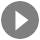
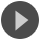

完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.790024
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=相对原子质量最小的稀有气体是?&q2=&q3=氖+氦+氪&q4=&rn=50
question: 相对原子质量最小的稀有气体是?
('B', '氦', 1.9018330575199798)
('C', '氪', 0.2815164765052032)
('A', '氖', 0.15676829405128956)


完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.265058
正在等待答题框出现，答题框相似度: 0.221446
正在等待答题框出现，答题框相似度: 0.151815
正在等待答题框出现，答题框相似度: 0.235856
正在等待答题框出现，答题框相似度: 0.226434
正在等待答题框出现，答题框相似度: 0.199557
正在等待答题框出现，答题框相似度: 0.214228
正在等待答题框出现，答题框相似度: 0.770567
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=毛泽东诗句“虎踞龙盘今胜昔"说的是哪个城市?&q2=&q3=长沙+贵阳+南京&q4=&rn=50
question: 毛泽东诗句“虎踞龙盘今胜昔"说的是哪个城市?
('C', '南京', 1.9843597412109375)
('A', '长沙', 0)
('B', '贵阳', 0)


完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.218916
正在等待答题框出现，答题框相似度: 0.231622
正在等待答题框出现，答题框相似度: 0.203084
正在等待答题框出现，答题框相似度: 0.203231
正在等待答题框出现，答题框相似度: 0.786702
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=一般来说树枝上哪部分叶子最后枯落?&q2=&q3=树干+靠近+部分+树枝中部+树梢部分&q4=&rn=50
question: 一般来说树枝上哪部分叶子最后枯落?
('A', '靠近树干部分', 1.998046874067768)
('C', '树梢部分', 1.4931001053018917)
('B', '树枝中部', 1.0019531250004547)


完成搜索，进入待机状态
待机中，按回车键继续，按q退出
q


In [17]:
game = 'baiwan'
engine = 'baidu'

STATE_STANDBY = 0
STATE_PARSING = 1
STATE_COOLDOWN = 2

state = STATE_COOLDOWN

if game == 'baiwan':
    questionbox_template = cv2.imread('template_baiwan.jpg')

while True:
    if state == STATE_STANDBY:
        im = capture_img()
        
        match = cv2.matchTemplate(im,
            questionbox_template,
            cv2.TM_CCOEFF_NORMED)
        print('正在等待答题框出现，答题框相似度:', match.max())
        if match.max() > 0.6:
            # 等待文字显示动画完成
            print('发现答题框，正在等待题目文字显示完成……')
            time.sleep(0.5)
            state = STATE_PARSING
        else:
            time.sleep(0.1)
    elif state == STATE_PARSING:
        print('正在解析……')
        im = capture_img()
        
        match = cv2.matchTemplate(im,
            questionbox_template,
            cv2.TM_CCOEFF_NORMED)
#         print(match)
        if match.max() > 0.6:
            ok = search_ans_from_pic(im[:1200,:,:], game=game)
            
            if ok:
                print('完成搜索，进入待机状态')
                state = STATE_COOLDOWN
            else:
                print('未找到答案，重新解析题目文本……')
                time.sleep(0.1)
        else:
            print('答题框消失，进入等待状态')
            state = STATE_STANDBY
    elif state == STATE_COOLDOWN:
        print('待机中，按回车键继续，按q退出')
        ipt = input()
        if ipt != 'q':
            print('进入等待状态……')
            state = STATE_STANDBY
        else:
            break

In [12]:
with open('questions.txt','r') as f:
    i = 0
    for line in f:
        question, opt_a, opt_b, opt_c = map(lambda s:s.strip(), line.split(','))
        
        search_ans(question, opt_a, opt_b, opt_c)
        time.sleep(1)
        i += 1
        if i > 100:
            break

http://www.baidu.com/s?q1=杨万里的《小池》中“小荷才露尖尖角"蜻蜓,蝴蝶,蜜蜂哪种动物落在了荷花上?&q2=&q3=&q4=&rn=50
[(蜻蜓, 5.957168237348997), (蝴蝶, 1.9823462600457467), (蜜蜂, 1.982010705891236), (, 0.0), (, 0.0), (蝶, 0.0), (, 0.0)]
question: 杨万里的《小池》中“小荷才露尖尖角"蜻蜓,蝴蝶,蜜蜂哪种动物落在了荷花上?
('A', '蜻蜓', 5.957168237348997)
('B', '蝴蝶', 1.9823462600457467)
('C', '蜜蜂', 1.982010705891236)


http://www.baidu.com/s?q1=中国古代历史上哪位皇帝写的诗最多?&q2=&q3=&q4=&rn=50
question: 中国古代历史上哪位皇帝写的诗最多?
('A', '乾隆', 0.6211586905424245)
('B', '康熙', 0.0)
('C', '朱元璋', 0.0)


http://www.baidu.com/s?q1=“云想衣裳花想容春风拂槛露华浓"是李白为下列哪一位所作?&q2=&q3=&q4=&rn=50
question: “云想衣裳花想容春风拂槛露华浓"是李白为下列哪一位所作?
('A', '杨贵妃', 1.1393835181319307)
('B', '李师师', 0.0)
('C', '武则天', 0.0)


http://www.baidu.com/s?q1=“人生自是有情痴此恨不关风与月”的作者还写过以下哪部词作?&q2=&q3=&q4=&rn=50


question: “人生自是有情痴此恨不关风与月”的作者还写过以下哪部词作?
('A', '《声声慢·寻寻觅觅》', 0.0)
('B', '《生查子元夕》', 0.0)
('C', '《鹊桥仙·纤云弄巧》', 0.0)


http://www.baidu.com/s?q1=“士不可以不弘毅任重而道远”这句论语中的名言谁说的?&q2=&q3=&q4=&rn=50
[(孔子, 0.1679197170945359), (孟子, 0.0), (曾子, 2.535073547393177), (中国, 0.0), (中国, 0.0)]


question: “士不可以不弘毅任重而道远”这句论语中的名言谁说的?
('C', '曾子', 2.535073547393177)
('A', '孔子', 0.1679197170945359)
('B', '孟子', 0.0)


http://www.baidu.com/s?q1=“大河向东流哇天上的星星参北斗哇“这首歌的名字叫?&q2=&q3=&q4=&rn=50
question: “大河向东流哇天上的星星参北斗哇“这首歌的名字叫?
('A', '《好汉歌》', 2.9091246240173003)
('B', '《大风歌》', 0.0)
('C', '《男儿当自强》', 0.0)


http://www.baidu.com/s?q1=“小时不识月呼作白玉盘”中“白玉盘"指什么?&q2=&q3=&q4=&rn=50
[(太阳, 0.0), (月亮, 1.6066256537975017), (金星, 0.0), (, 0.0), (昡, 0.0), (昱, 0.0), (曦, 0.0), (阳光, 0.0), (白日, 0.0), (日, 0.03439365648208115), (曜, 0.0), (日光, 0.0), (日头, 0.0), (烨, 0.0), (晖, 0.0), (, 0.0), (太阴, 0.0), (月, 16.259451585331362), (月球, 0.0), (卫星, 0.0), (, 0.0)]


question: “小时不识月呼作白玉盘”中“白玉盘"指什么?
('B', '月亮', 17.866077239128863)
('A', '太阳', 0.03439365648208115)
('C', '金星', 0.0)


"“小时不识月,呼作白玉盘。”的全诗是什么?",16个回答,2008-02-18
"小时不识月,呼作白玉盘。这首诗后面的是什么?",9个回答,2006-08-22


http://www.baidu.com/s?q1=“忽如一夜春风来干树万树梨花开"所形容的景色是在哪一个季&q2=&q3=&q4=&rn=50
[(春季, 0.31319974366225767), (秋季, 0.0), (冬季, 1.755617977181824), (, 0.0), (阳春, 0.0), (春日, 0.0), (春, 0.0), (春天, 0.0333824947683297), (春令, 0.0), (, 0.0), (秋天, 0.0), (秋, 0.0), (秋令, 0.0), (, 0.0), (冬令, 0.0), (冬日, 0.0), (冬, 0.31335593987887206), (冬天, 1.7424989861928417)]
question: “忽如一夜春风来干树万树梨花开"所形容的景色是在哪一个季
('C', '冬季', 3.811472903253538)
('A', '春季', 0.3465822384305874)
('B', '秋季', 0.0)


http://www.baidu.com/s?q1=“桃李满天下”中的“桃李”一般用来指代?&q2=&q3=&q4=&rn=50
[(老师, 0.9354680236246674), (学生, 6.617369656608794), (前辈, 0.0), (, 0.0), (师长, 0.0), (, 0.0), (门徒, 0.0), (弟子, 0.0768941165667404), (生, 0.0), (门下, 0.0), (门生, 0.0), (徒弟, 0.0), (, 0.0)]
question: “桃李满天下”中的“桃李”一般用来指代?
('B', '学生', 6.694263773175535)
('A', '老师', 0.9354680236246674)
('C', '前辈', 0.0)


http://www.baidu.com/s?q1=“鳄鱼的眼泪"通常用来形容人的哪一种品性?&q2=&q3=&q4=&rn=50
[(伪善, 0.0), (善良, 0.07978411726020779), (凶残, 0.0), (, 0.0), (仁, 0.0), (仁爱, 0.0), (, 0.0)]
question: “鳄鱼的眼泪"通常用来形容人的哪一种品性?
('B', '善良', 0.07978411726020779)
('A', '伪善', 0.0)
('C', '凶残', 0.0)


http://www.baidu.com/s?q1=《瓦尔登湖》、《霍乱时期的爱情》、《远大前程》哪部作品的作者&q2=&q3=&q4=&rn=50
question: 《瓦尔登湖》、《霍乱时期的爱情》、《远大前程》哪部作品的作者
('B', '《霍乱时期的爱情》', 29.033646807884093)
('A', '《瓦尔登湖》', 6.232464439349418)
('C', '《远大前程》', 5.971643084485263)


http://www.baidu.com/s?q1=《白雪公主》选自哪部经典作品?&q2=&q3=&q4=&rn=50
question: 《白雪公主》选自哪部经典作品?
('B', '《安徒生童话》', 3.4864160908809922)
('A', '《格林童话》', 2.149436903072462)
('C', '《伊索寓言》', 0.0)


http://www.baidu.com/s?q1=《马里奥》系列游戏中马里奥吃哪种植物可以体积变大?&q2=&q3=&q4=&rn=50
question: 《马里奥》系列游戏中马里奥吃哪种植物可以体积变大?
('A', '蘑菇', 3.52776997532736)
('B', '土豆', 0.692685883109891)
('C', '西红柿', 0.0)


http://www.baidu.com/s?q1=一个蚂蚁社群中负责产卵繁殖处于最核心地位的成员通常被称为?&q2=&q3=&q4=&rn=50
[(蚁后, 2.6165740598367515), (蚁王, 0.0), (工蚁, 0.0), (, 0.0)]
question: 一个蚂蚁社群中负责产卵繁殖处于最核心地位的成员通常被称为?
('A', '蚁后', 2.6165740598367515)
('B', '蚁王', 0.0)
('C', '工蚁', 0.0)


http://www.baidu.com/s?q1=一些小伤口流血之后会自行凝结结痂是因为血液中含有哪种成分?&q2=&q3=&q4=&rn=50
question: 一些小伤口流血之后会自行凝结结痂是因为血液中含有哪种成分?
('A', '红细胞', 2.7933566329880883)
('B', '血小板', 2.5869419278897974)
('C', '白细胞', 1.6013718185037016)


http://www.baidu.com/s?q1=一般来说树枝上哪部分叶子最后枯落?&q2=&q3=&q4=&rn=50
question: 一般来说树枝上哪部分叶子最后枯落?
('C', '树梢部分', 11.411201706922602)
('B', '树枝中部', 11.31538180507507)
('A', '靠近树干部分', 9.609642185581501)


http://www.baidu.com/s?q1=三毛的经典名句“每想你一次天上飘落一粒沙”从此形成了哪个沙&q2=&q3=&q4=&rn=50
question: 三毛的经典名句“每想你一次天上飘落一粒沙”从此形成了哪个沙
('C', '戈壁沙漠', 0.4753252157538469)
('A', '塔克拉玛干沙漠', 0.0)
('B', '撒哈拉沙漠', 0.0)


http://www.baidu.com/s?q1=下列动物中哪一种不属于冷血动物?&q2=&q3=&q4=&rn=50
[(乌龟, 0.0), (鳄鱼, 0.0), (鲸鱼, 1.6558200235216107), (, 0.0), (金龟, 0.0), (龟, 0.0), (王八, 0.0), (, 0.0), (鳄, 0.0), (, 0.0), (鲸, 1.0112695583283817)]


question: 下列动物中哪一种不属于冷血动物?
('C', '鲸鱼', 2.6670895818499925)
('A', '乌龟', 0.0)
('B', '鳄鱼', 0.0)


http://www.baidu.com/s?q1=下列哪一个国家不属于“金砖国家”?&q2=&q3=&q4=&rn=50


question: 下列哪一个国家不属于“金砖国家”?
('C', '新加坡', 3.4119287787583037)
('A', '中国', 2.801390942121475)
('B', '巴西', 1.8838730572031734)


http://www.baidu.com/s?q1=下列哪一种物质的主要化学成分与其他两种不同?&q2=&q3=&q4=&rn=50


question: 下列哪一种物质的主要化学成分与其他两种不同?
('A', '大理石', 0.4560774705899929)
('B', '水晶', 0.0)
('C', '珍珠', 0.0)


http://www.baidu.com/s?q1=下列哪一种物质的硬度最高?&q2=&q3=&q4=&rn=50
question: 下列哪一种物质的硬度最高?
('C', '金刚石', 1.80310238371874)
('A', '金', 0.0)
('B', '银', 0.0)


http://www.baidu.com/s?q1=下列哪一种能源是可再生能源?&q2=&q3=&q4=&rn=50
[(煤炭, 0.0), (石油, 0.684270284899685), (风能, 1.1546451381454002), (, 0.0), (乌金, 0.0), (煤, 1.285424380195591), (, 0.0), (油, 0.0), (, 0.0)]
question: 下列哪一种能源是可再生能源?
('A', '煤炭', 1.285424380195591)
('C', '风能', 1.1546451381454002)
('B', '石油', 0.684270284899685)


http://www.baidu.com/s?q1=下列河流哪一条是世界流程最长?&q2=&q3=&q4=&rn=50
question: 下列河流哪一条是世界流程最长?
('A', '尼罗河', 4.087310473424539)
('B', '长江', 0.7400349115300416)
('C', '亚马孙河', 0.13730506182594257)


http://www.baidu.com/s?q1=世界上第一家电视台出现在英国,美国,法国哪个国家&q2=&q3=&q4=&rn=50
[(英国, 9.091888781589894), (美国, 10.794421765064559), (法国, 7.545225940307949), (英, 2.006244956142005), (欧洲, 0.06495329946704688), (Q, 0.0), (g, 0.0), (E, 0.0), (h, 0.0), (S, 0.0), (牛顿, 0.0), (l, 0.0), (雪莱, 0.0), (e, 0.0), (j, 0.0), (W, 0.0), (拜伦, 0.0), (白厅, 0.0), (Z, 0.0), (n, 0.0), (a, 0.39969338993470693), (d, 0.0), (C, 1.136424585918963), (w, 0.0), (乔叟, 0.0), (y, 0.0), (q, 0.0), (F, 0.0), (剑桥, 0.0), (H, 0.0), (D, 0.1265884639664984), (镑, 0.0), (伦敦, 0.0), (s, 0.0), (t, 0.0), (M, 0.0), (k, 0.0), (r, 0.0), (A, 4.429423180023959), (L, 0.0), (T, 0.0), (V, 0.0), (i, 0.0), (m, 0.0), (便士, 0.0), (英文, 0.0), (英镑, 0.0), (o, 0.0), (P, 0.0), (p, 0.0), (英制, 0.0), (J, 0.0), (I, 0.0), (f, 0.0), (O, 0.0), (u, 0.0), (c, 0.39979478952180947), (英, 2.006244956142005), (R, 0.0), (B, 4.132886877166684), (x, 0.0), (v, 0.0), (K, 0.0), (N, 0.0), (Y, 0.0), (U, 0.0), (X, 0.0), (z, 0.0), (b, 0.3997481821671437), (G, 0.0), (北美, 0.0), (美, 0.0), (费城

http://www.baidu.com/s?q1=世界上销量最多的酒是啤酒,,白酒哪种?&q2=&q3=&q4=&rn=50
[(啤酒, 11.058098653792788), (, 0.0), (白酒, 3.128777872749392), (, 0.0), (啤, 0.38735233126428253), (, 0.0), (烧酒, 0.0)]
question: 世界上销量最多的酒是啤酒,,白酒哪种?
('A', '啤酒', 11.44545098505707)
('C', '白酒', 3.128777872749392)
('B', '', 0.0)


"啤酒,红酒,白酒,谁才是世界上销量最大的酒",1个回答,2017-06-12


http://www.baidu.com/s?q1=中国探测暗物质的科学卫星的名&q2=&q3=&q4=&rn=50
[(悟空, 3.857092823955609), (八戒, 0.0), (沙僧, 0.0)]
question: 中国探测暗物质的科学卫星的名
('A', '悟空', 3.857092823955609)
('B', '八戒', 0.0)
('C', '沙僧', 0.0)


http://www.baidu.com/s?q1=人们经常通过注射外源性胰岛素的方法来治疗以下哪种疾病?&q2=&q3=&q4=&rn=50
question: 人们经常通过注射外源性胰岛素的方法来治疗以下哪种疾病?
('B', '糖尿病', 2.357042362614286)
('A', '高血压', 0.0)
('C', '骨质疏松', 0.0)


http://www.baidu.com/s?q1=以下三条河流的对比中哪条河流最长?&q2=&q3=&q4=&rn=50
question: 以下三条河流的对比中哪条河流最长?
('A', '多瑙河', 0.0)
('B', '湄公河', 0.0)
('C', '伏尔塔瓦河', 0.0)


http://www.baidu.com/s?q1=以下哪一部不是知名作家郭敬明的作品?&q2=&q3=&q4=&rn=50


question: 以下哪一部不是知名作家郭敬明的作品?
('A', '三重门', 2.0098268671047497)
('B', '小时代', 0.5598640557369907)
('C', '幻城', 0.37597744247315923)


http://www.baidu.com/s?q1=以下哪一部影片的故事不是改编自小说?&q2=&q3=&q4=&rn=50


question: 以下哪一部影片的故事不是改编自小说?
('C', '罗马假日', 5.067639204153217)
('A', '教父', 0.0)
('B', '肖申克的救赎', 0.0)


http://www.baidu.com/s?q1=以下哪个体育项目是通过裁判打分来决定胜负的?&q2=&q3=&q4=&rn=50
question: 以下哪个体育项目是通过裁判打分来决定胜负的?
('A', '跳水', 2.068518287792904)
('B', '100米短跑', 0.0)
('C', '羽毛球', 0.0)


http://www.baidu.com/s?q1=以下哪个海沟最深?&q2=&q3=&q4=&rn=50
question: 以下哪个海沟最深?
('A', '马里亚纳海沟', 31.285484693971526)
('B', '波多黎各海沟', 23.76195379309251)
('C', '菲律宾海沟', 23.584758991307098)


http://www.baidu.com/s?q1=以下哪项是磁悬浮列车的主要阻力?&q2=&q3=&q4=&rn=50
question: 以下哪项是磁悬浮列车的主要阻力?
('B', '行进时的空气', 4.437663208337208)
('C', '磁悬浮力', 0.36110123423617646)
('A', '与铁轨的摩擦力', 0.0)


http://www.baidu.com/s?q1=以下哪首不是张学友原唱的歌曲?&q2=&q3=&q4=&rn=50


question: 以下哪首不是张学友原唱的歌曲?
('A', '《爱如潮水》', 4.292415504685848)
('B', '《心如刀割》', 0.0)
('C', '《吻别》', 0.0)


http://www.baidu.com/s?q1=名句“日出江花红胜火春来江水绿如蓝"出自哪位诗人的作品?&q2=&q3=&q4=&rn=50
question: 名句“日出江花红胜火春来江水绿如蓝"出自哪位诗人的作品?
('A', '白居易', 4.289167810957396)
('B', '李白', 0.0)
('C', '杜甫', 0.0)


http://www.baidu.com/s?q1=吴承恩所著的《西游记》中牛魔王会多少种变化?&q2=&q3=&q4=&rn=50
question: 吴承恩所著的《西游记》中牛魔王会多少种变化?
('C', '72种', 3.1780093105516807)
('A', '36种', 0.0)
('B', '64种', 0.0)


http://www.baidu.com/s?q1=唐太宗的原名叫?&q2=&q3=&q4=&rn=50
question: 唐太宗的原名叫?
('B', '李世民', 5.256621748907073)
('A', '李渊', 0.6809815519748814)
('C', '李隆基', 0.34166679945658057)


李世民原名是什么,4个回答,2014-10-16


http://www.baidu.com/s?q1=在哈尔滨哪个节日最可能下雪?&q2=&q3=&q4=&rn=50
question: 在哈尔滨哪个节日最可能下雪?
('C', '圣诞节', 2.6413431703347676)
('A', '儿童节', 0.0)
('B', '中秋节', 0.0)


http://www.baidu.com/s?q1=在小于500的自然数中能被11整除的数有多少个?&q2=&q3=&q4=&rn=50
[(42, 0.0), (45, 0.3757418391508415), (47, 0.0)]
question: 在小于500的自然数中能被11整除的数有多少个?
('B', '45', 0.3757418391508415)
('A', '42', 0.0)
('C', '47', 0.0)


"在小于500的自然数中,能被11整除的数有多少个?",1个回答,2018-01-30


http://www.baidu.com/s?q1=在战国初期下列哪一个国家未与燕国相邻?&q2=&q3=&q4=&rn=50
[(赵国, 1.4280695119718565), (楚国, 1.5766353608024348), (齐国, 1.4531683994316347)]


question: 在战国初期下列哪一个国家未与燕国相邻?
('B', '楚国', 1.5766353608024348)
('C', '齐国', 1.4531683994316347)
('A', '赵国', 1.4280695119718565)


http://www.baidu.com/s?q1=在每一年的NBA联赛之中下列哪一系列比赛最先进行?&q2=&q3=&q4=&rn=50
question: 在每一年的NBA联赛之中下列哪一系列比赛最先进行?
('B', '常规赛', 1.967201767881459)
('C', '季后赛', 1.2980810002605634)
('A', '季前赛', 0.09131393949413696)


http://www.baidu.com/s?q1=在真空条件下铁球和羽毛同高度同时下落谁先落地?&q2=&q3=&q4=&rn=50
question: 在真空条件下铁球和羽毛同高度同时下落谁先落地?
('C', '同时落地', 23.783828178351563)
('A', '羽毛', 11.318581232018694)
('B', '铁球', 7.937044198648916)


ValueError: too many values to unpack (expected 4)

In [10]:
with open('questions.txt','r') as f:
    with open('questions.tmp.txt','w') as wf:
        lines = sorted(list(set(f.readlines())))
        for line in lines:
            s = line.strip()
            if s != '':
                wf.write(s + '\n')